In [15]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime as dt

from hmmlearn import hmm

import sys
sys.path.append('../')

In [16]:
df = pd.read_csv('../DB/1D/BTCUSDT_1D.csv', parse_dates=True) 

# df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
# # # Convert 'date' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])  # Assuming the 'date' is in milliseconds

# # # Set 'date' as index
df.set_index('datetime', inplace=True)
df = df.loc[:,['open',	'high',	'low',	'close','volume']]
df

,open,high,low,close,volume
datetime,,,,,
2019-07-08 16:00:00,12374.20,12391.47,12156.27,12340.55,0
2019-07-09 16:00:00,12340.55,13140.30,12114.15,12363.18,0
2019-07-10 16:00:00,12363.18,12363.18,11204.86,11487.25,0
2019-07-11 16:00:00,11487.25,11749.67,11001.11,11474.45,0
2019-07-12 16:00:00,11474.45,11878.53,11194.44,11411.80,0
...,...,...,...,...,...
2025-01-11 16:00:00,94363.40,95418.10,93675.80,95034.70,0
2025-01-12 16:00:00,95034.70,95886.30,89302.10,92114.40,0
2025-01-13 16:00:00,92114.40,97343.30,91217.30,96421.70,0


In [17]:
df['log_return'] = np.log(df['close']) - np.log(df['close'].shift(1))

In [18]:
df.describe()

,open,high,low,close,volume,log_return
count,2019.000000,2019.000000,2019.000000,2019.000000,2019.0,2018.000000
mean,34339.841956,35135.585136,33514.818356,34383.653814,0.0,0.001033
std,22171.345001,22653.275674,21680.000176,22213.724055,0.0,0.033210
min,5158.450000,5437.230000,3804.400000,5158.450000,0.0,-0.238414
25%,16508.695000,16649.235000,16199.050000,16511.910000,0.0,-0.013693
50%,29580.700000,30221.540000,29084.690000,29625.650000,0.0,0.001339
75%,48623.690000,49849.245000,47144.130000,48656.515000,0.0,0.015410
max,106434.300000,108306.900000,105427.600000,106434.300000,0.0,0.164406


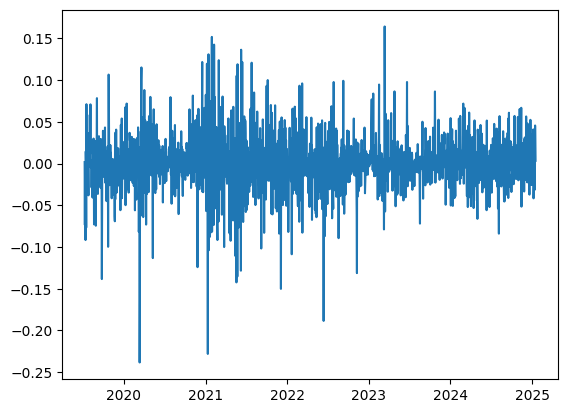

In [19]:
plt.plot(df['log_return'])


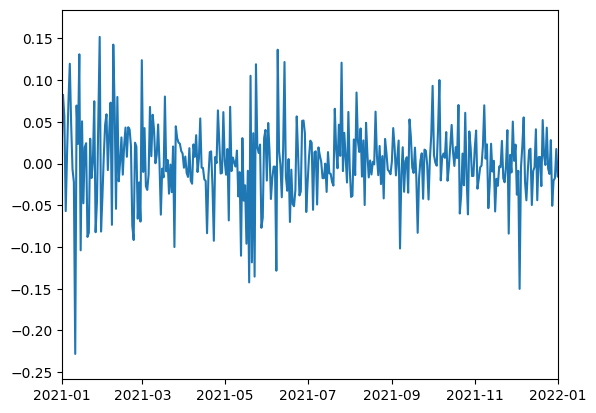

In [20]:
plt.plot(df['log_return'])
plt.xlim(dt(2021,1,1), dt(2022,1,1))
plt.show()

Model is not converging.  Current: 4254.737087581722 is not greater than 4254.7413450778395. Delta is -0.0042574961171339964


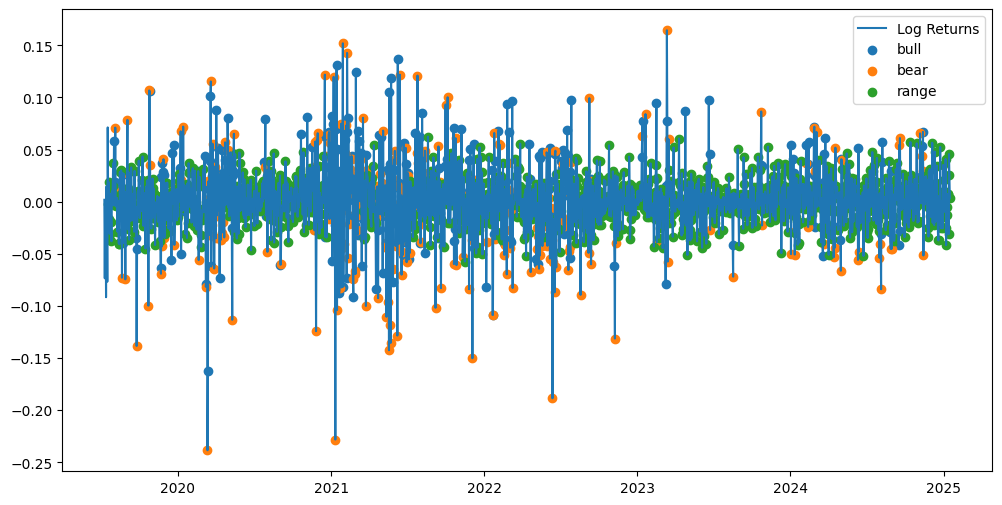

In [21]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt

# États du marché
states = ['bull', 'bear', 'range']
n_state = len(states)

# Nettoyage des données
df['log_return'] = df['log_return'].dropna()

# Série temporelle des rendements logarithmiques
log_return_series = df['log_return'][10:]  # Skipping initial values
log_return = log_return_series.values.reshape(-1, 1)

# Création et entraînement du modèle HMM
model = hmm.GaussianHMM(n_components=n_state, covariance_type="diag", n_iter=100, random_state=42)
model.fit(log_return)

# Prédiction des états cachés
hidden_states = model.predict(log_return)

# Ajouter les états cachés au DataFrame
df['hidden_state'] = np.nan
df.loc[log_return_series.index, 'hidden_state'] = hidden_states

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(df['log_return'], label='Log Returns')
for state in range(n_state):
    plt.scatter(
        df.index[df['hidden_state'] == state],
        df['log_return'][df['hidden_state'] == state],
        label=states[state]
    )
plt.legend()
plt.show()


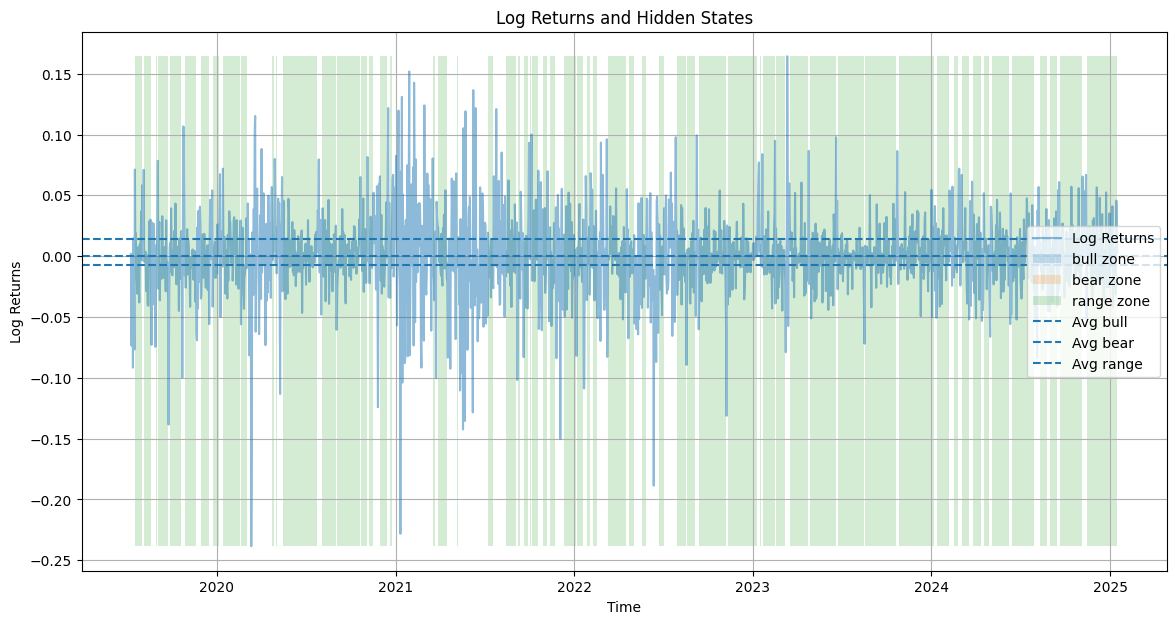

In [30]:
plt.figure(figsize=(14, 7))

# Afficher les rendements
plt.plot(df.index, df['log_return'], label='Log Returns', alpha=0.5)

# Afficher les zones par état
for state in range(n_state):
    plt.fill_between(
        df.index,
        df['log_return'].min(),
        df['log_return'].max(),
        where=df['hidden_state'] == state,
        alpha=0.2,
        label=f"{states[state]} zone"
    )

# Afficher une ligne moyenne des rendements pour chaque état
for state in range(n_state):
    avg_return = df['log_return'][df['hidden_state'] == state].mean()
    plt.axhline(avg_return, linestyle='--', label=f"Avg {states[state]}")

# Ajouter des labels et une légende
plt.title("Log Returns and Hidden States")
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.legend()
plt.grid()
plt.show()


In [31]:
print(df['hidden_state'].value_counts())


hidden_state
2.0    1407
0.0     301
1.0     301
Name: count, dtype: int64


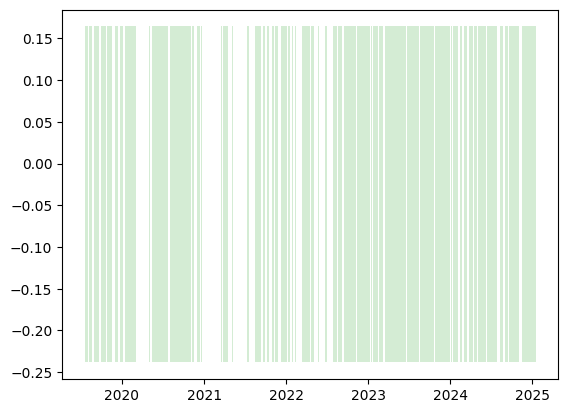

In [32]:
for state, label in zip([0, 1, 2], ['bull zone', 'bear zone', 'range zone']):
    plt.fill_between(
        df.index,
        df['log_return'].min(),
        df['log_return'].max(),
        where=df['hidden_state'] == state,
        alpha=0.2,
        label=label
    )


In [33]:
# Analyser les moyennes et les variances des états
for state in range(3):
    subset = df[df['hidden_state'] == state]['log_return']
    print(f"State {state}: Mean = {subset.mean()}, Std = {subset.std()}")


State 0: Mean = 0.013921860133406329, Std = 0.0450420912729174
State 1: Mean = -0.007534835526676686, Std = 0.05868580634050736
State 2: Mean = 0.00023453329809144604, Std = 0.01856000721962043


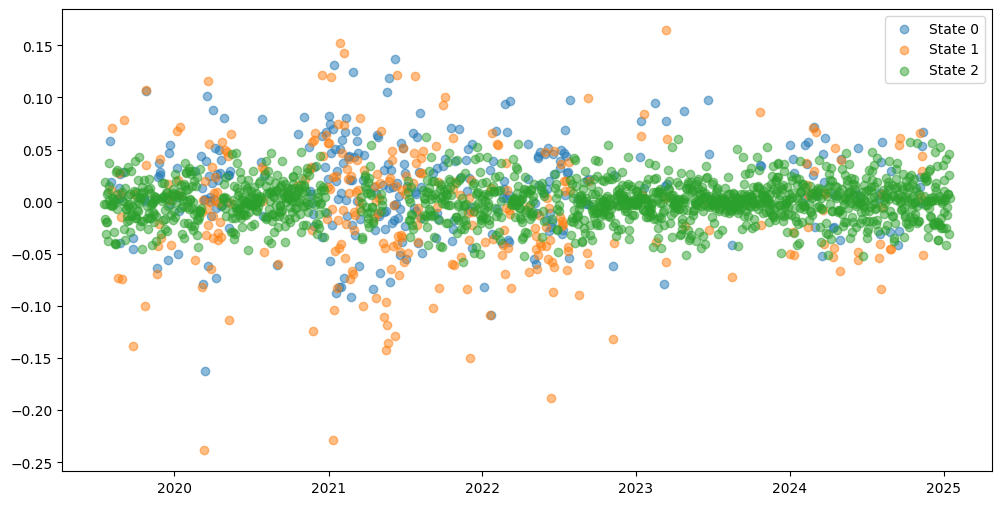

In [34]:
# Tracé des clusters
plt.figure(figsize=(12, 6))
for state in range(3):
    subset = df[df['hidden_state'] == state]
    plt.scatter(subset.index, subset['log_return'], label=f"State {state}", alpha=0.5)
plt.legend()
plt.show()


In [36]:
hmm_model = hmm.GaussianHMM(n_components=3, covariance_type='full')


In [37]:
df['log_return_normalized'] = (df['log_return'] - df['log_return'].mean()) / df['log_return'].std()


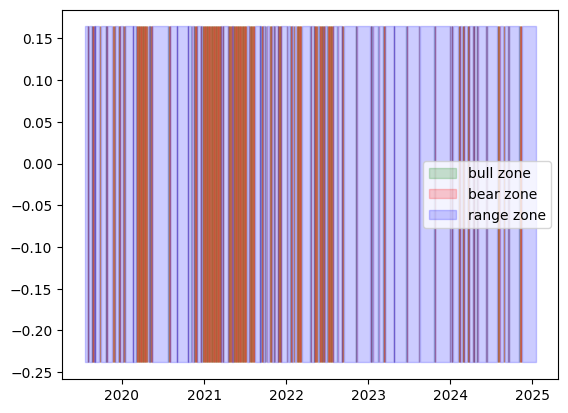

In [38]:
colors = ['green', 'red', 'blue']
for state, (label, color) in enumerate(zip(['bull zone', 'bear zone', 'range zone'], colors)):
    plt.fill_between(
        df.index,
        df['log_return'].min(),
        df['log_return'].max(),
        where=df['hidden_state'] == state,
        color=color,
        alpha=0.2,
        label=label
    )
plt.legend()
plt.show()
